# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import scipy.misc 
import datetime
import os
import random
from skimage import transform,io
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, GRU, SimpleRNN, Flatten, Bidirectional, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from tensorflow.keras import regularizers
from keras.applications import VGG16, MobileNet



Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.random.set_seed(30)
tf.set_random_seed(30)

In [3]:
def generator(source_path, folder_list, batch_size, x=7,y=120,z=120):

    img_idx = sorted(random.sample(range(0, 30), x)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches =len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = transform.resize(image,(y,z))
                    normalized_img = resized_img/127.5-1 #Normalize data
                    batch_data[folder,idx,:,:,0] =normalized_img[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =normalized_img[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =normalized_img[:,:,0] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = transform.resize(image,(y,z))
                    normalized_img = resized_img/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (normalized_img[:,:,0])
                    batch_data[folder,idx,:,:,1] = (normalized_img[:,:,1])
                    batch_data[folder,idx,:,:,2] = (normalized_img[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [4]:
line_separator = "================================================="
dummy = "dummy"

In [5]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [6]:
def run_model_for_batch(batch_size, x, y, z, model_name_prefix, train_path, val_path, train_doc_full_path, val_doc_full_path, rnn_units=6, type_rnn="GRUbi", momentum_val=0.7):
    try:
        print(type_rnn," is type of rnn")
        print(model_name_prefix," is model_name_prefix")
        print(rnn_units," gru units taken")
        train_doc = np.random.permutation(open(train_doc_full_path).readlines())
        val_doc = np.random.permutation(open(val_doc_full_path).readlines())    
        num_train_sequences = len(train_doc)
        print('# training sequences =', num_train_sequences)
        num_val_sequences = len(val_doc)
        print('# validation sequences =', num_val_sequences)
        num_epochs = 150# choose the number of epochs
        print ('# epochs =', num_epochs)    


        train_generator = generator(train_path, train_doc, batch_size,x,y,z)
        val_generator = generator(val_path, val_doc, batch_size,x,y,z)
        curr_dt_time = datetime.datetime.now()


        conv_base = VGG16(weights='imagenet',
                      # do not include the top, fully-connected Dense layers 
                      include_top=False
                      ,input_shape=(y, z, 3))

        for layer in conv_base.layers:
            layer.trainable = False


        input_shape = Input(shape=(x, y, z, 3))
        vgg1= TimeDistributed(conv_base )(input_shape)
        flatten= TimeDistributed(Flatten()) (vgg1)
        print("setting momentum:",momentum_val)

        if type_rnn is "RNN":
            rnn = SimpleRNN(rnn_units,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5))(flatten)#TODO check
        elif type_rnn is "GRU":
            rnn = GRU(rnn_units,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5))(flatten)#TODO check
        elif type_rnn is "LSTM":
            rnn = LSTM(rnn_units,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5))(flatten)#TODO check
        elif type_rnn is "GRUbi":
            rnn = Bidirectional(GRU(rnn_units,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))(flatten)#TODO check
        elif type_rnn is "LSTMbi":
            rnn = Bidirectional(LSTM(rnn_units,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))(flatten)#TODO check

    #         first_feed_forward = Dense(10, activation="relu",kernel_regularizer=regularizers.l2(1e-4),    bias_regularizer=regularizers.l2(1e-4),    activity_regularizer=regularizers.l2(1e-5))(rnn)
        output = Dense(5, activation='softmax', name='output')(rnn)
        model = Model(outputs=output, inputs= input_shape)


        optimiser =  optimizers.SGD(lr=0.001, decay=0.000001, momentum=momentum_val, nesterov=True)#write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (model.summary())


        model_name = model_name_prefix + '_' + str(batch_size) + '_directdense' +  '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'




        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=4, min_lr=0.00005)# write the REducelronplateau code here
        ES = EarlyStopping( monitor="val_loss", patience=45,    verbose=0,    mode="auto",    baseline=None)
        callbacks_list = [checkpoint, LR, ES]




        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
        print(validation_steps)  

        history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps,
                         class_weight=None, workers=1, initial_epoch=0)


        plot_history(history)
        return history

    except:
        return dummy
    
    

In [7]:
dict_history_batchsize = {}

Evaluating models for type_rnn: GRU momentum: 0.99 __rnn_unit: 56 and image_count: 16  image_size: 120  and batch_size: 24
2020-08-23 21:46:31
GRU  is type of rnn
VGG_Experimental_probfinal_56unit_GRU_120_24_56_16  is model_name_prefix
56  gru units taken
# training sequences = 663
# validation sequences = 100
# epochs = 150
setting momentum: 0.99
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16, 120, 120, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 4608)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 56)                783720    
________________________________________________________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


28/28 [==============================] - 88s 3s/step - loss: 1.7762 - categorical_accuracy: 0.3000 - val_loss: 1.4995 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 1.49952, saving model to VGG_Experimental_probfinal_56unit_GRU_120_24_56_16_24_directdense/model-00001-1.77910-0.29864-1.49952-0.46000.h5
Epoch 2/150
28/28 [==============================] - 33s 1s/step - loss: 1.2793 - categorical_accuracy: 0.6119 - val_loss: 1.1052 - val_categorical_accuracy: 0.7000

Epoch 00002: val_loss improved from 1.49952 to 1.10523, saving model to VGG_Experimental_probfinal_56unit_GRU_120_24_56_16_24_directdense/model-00002-1.27931-0.61190-1.10523-0.70000.h5
Epoch 3/150
28/28 [==============================] - 29s 1s/step - loss: 1.0576 - categorical_accuracy: 0.6662 - val_loss: 1.1111 - val_categorical_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 1.10523
Epoch 4/150
28/28 [==============================] - 9s 314ms/step - loss: 1.1126 - categorical_a

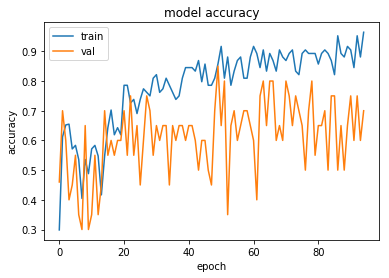

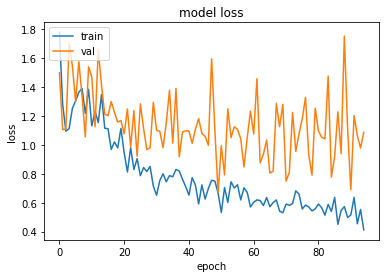

2020-08-23 22:03:33
Evaluating models for type_rnn: GRU momentum: 0.99 __rnn_unit: 64 and image_count: 16  image_size: 120  and batch_size: 24
2020-08-23 22:03:33
GRU  is type of rnn
VGG_Experimental_probfinal_56unit_GRU_120_24_64_16  is model_name_prefix
64  gru units taken
# training sequences = 663
# validation sequences = 100
# epochs = 150
setting momentum: 0.99
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 16, 120, 120, 3)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 4608)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                897216    
____________________________________

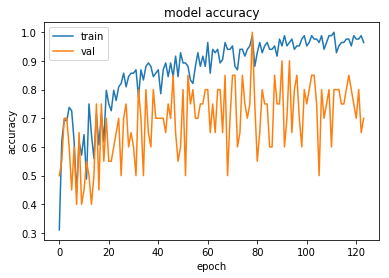

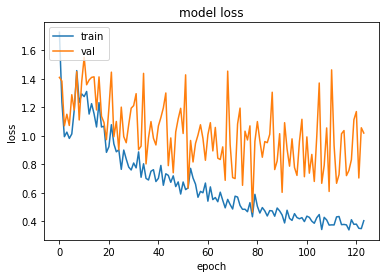

2020-08-23 22:24:49


In [8]:
rnn_units = [56, 64]#30 gru is already run
batch_sizes = [24]
image_sizes = [120]##No time to do for 180
image_counts = [16]#30 image count is already done
momentums = [ 0.99 ]
types=["GRU"]
dict_history_batchsize = {}
train_path = './Project_data/train'
val_path = './Project_data/val'
train_doc_full_path = './Project_data/train.csv'
val_doc_full_path = './Project_data/val.csv'
from time import strftime
          
res_times = {}          
for rnn_unit in rnn_units:
    dict_history_batchsize[rnn_unit] = {}
    for batch_size in batch_sizes:
        dict_history_batchsize[rnn_unit][batch_size] = {}
        for type_rnn in types:
            dict_history_batchsize[rnn_unit][batch_size][type_rnn] = {}
            for momentum in momentums:
                dict_history_batchsize[rnn_unit][batch_size][type_rnn][momentum] = {}        
                dict_history_batchsize[rnn_unit][batch_size][type_rnn][momentum] = {}
                for image_count in image_counts:
                    dict_history_batchsize[rnn_unit][batch_size][type_rnn][momentum][image_count] = {}
                    for image_size in image_sizes:
                        dict_history_batchsize[rnn_unit][batch_size][type_rnn][momentum][image_count][image_size] = {}
                        print(line_separator)
                        print("Evaluating models for type_rnn:",type_rnn,"momentum:",momentum,"__rnn_unit:", rnn_unit, "and image_count:", image_count, " image_size:", image_size, " and batch_size:", batch_size)
                        print(line_separator)
                        dict_history_batchsize[rnn_unit][batch_size][type_rnn][momentum][image_count][image_size] = None
                        x = image_count
                        y = image_size
                        z = image_size
                        a = datetime.datetime.now().replace(microsecond=0)
                        print(a)
                        model_name_prefix = "VGG_Experimental_probfinal_56unit"+ '_' + type_rnn+"_"+str(image_size)+"_"+str(batch_size)+"_"+str(rnn_unit)+"_"+str(image_count)
                        history = run_model_for_batch(batch_size, x, y, z, model_name_prefix, train_path, val_path, train_doc_full_path, val_doc_full_path, rnn_unit, type_rnn,momentum)
                        b = datetime.datetime.now().replace(microsecond=0)
                        print(b)
                        res_times[type_rnn+str(momentum)] = b-a
                        if history is not None:
                            dict_history_batchsize[rnn_unit][batch_size][type_rnn][momentum][image_count][image_size] = history
                        else:
                            dict_history_batchsize[rnn_unit][batch_size][type_rnn][momentum][image_count][image_size] = dummy



History for type_rnn: GRU __rnn_unit: 56 and image_count: 16  image_size: 120  and batch_size: 24
dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


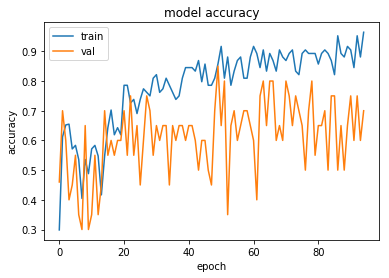

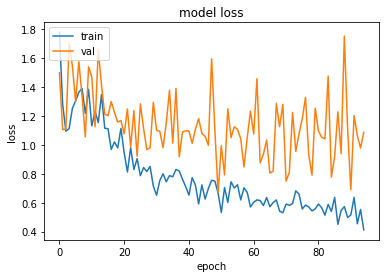

History for type_rnn: GRU __rnn_unit: 64 and image_count: 16  image_size: 120  and batch_size: 24
dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


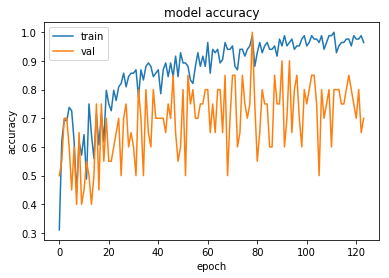

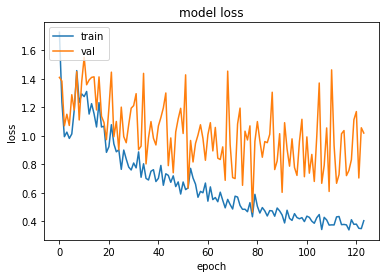

In [9]:
for type_rnn in types:
    for momentum in momentums:
        for rnn_unit in rnn_units:
            for image_count in image_counts:
                for image_size in image_sizes:
                    for batch_size in batch_sizes:
                        print(line_separator)
                        print("History for type_rnn:",type_rnn,"__rnn_unit:", rnn_unit, "and image_count:", image_count, " image_size:", image_size, " and batch_size:", batch_size)
                        retrieved = dict_history_batchsize[rnn_unit][batch_size][type_rnn][momentum][image_count][image_size]
                        if retrieved is not dummy and  retrieved is not None:
                            plot_history(retrieved)
                        else:
                            print("Failed to fetch history")
                        print(line_separator)


In [10]:
print(res_times)

{'GRU0.99': datetime.timedelta(0, 1276)}
